# Medición de diámetros a partir de una imagen patrón

In [1]:
from functions import *     # Funciones definidas en functions.py (Para VS Code agregar dir. en carpeta AppData, settings.json)
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from metas_unclib import *
use_linprop()
from tkinter import Tk, Toplevel  
from tkinter.filedialog import askopenfilename

In [8]:
DIR = "C:\\Users\\Admin\\Documents\\SEM Lineas de Aire\\Mediciones" # Completar con directorio base para varias imágenes

ENDEREZAR = True   # True para enderezar las imágenes
CANNY = True    # Define el método utilizado para la detección de bordes. Canny_Edges si True, Thresholding si False.
# Para cada método conviene optimizar previamente los hiperparámetros (como el umbral) según la imagen.

In [3]:
# Ventana para selección de archivos
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

path_patron = askopenfilename(filetypes=[("Archivo TIF", "*.tif"), ("Archivo BMP", "*.bmp"), ("All files", "*.*")], title='Seleccione Patrón', initialdir=DIR)
path_dut = askopenfilename(filetypes=[("Archivo TIF", "*.tif"), ("Archivo BMP", "*.bmp"), ("All files", "*.*")], title='Seleccione DUT', initialdir=DIR)

## Procesamiento

Utiliza uno de los métodos de deteccion y optimiza el ángulo de rotación (si ENDEREZAR = True). Siempre verificar la imagen de salida!

Comprobar las imágenes de entrada

In [15]:
# Comprobar las imágenes
SCALE = 75  # Factor de escala para visualización

patron = cv2.imread(path_patron)
patron = delete_bottom(patron, 60)
# patron = delete_left(patron, 10)
# patron = delete_right(patron, 10)
show_image(patron, SCALE)

dut = cv2.imread(path_dut)
dut = delete_bottom(dut, 60)
# dut = delete_left(dut, 10)
# dut = delete_right(dut, 10)
show_image(dut, SCALE)

### Definir los valores de umbral

In [16]:
if CANNY:
    fun = Canny_Edges
    two_params = True
else:
    fun = Thresholding
    two_params = False

dt1 = DefineThreshold(patron, fun, two_params, SCALE)
th1_pat, th2_pat = dt1.get_th()
dt1 = DefineThreshold(dut, fun, two_params, SCALE)
th1_dut, th2_dut = dt1.get_th()

# En principio se toma el mismo umbral para ambas (promedio)
th1 = (th1_pat + th1_dut)/2
th2 = (th2_pat + th2_dut)/2

print("Umbrales: ", th1, th2)
show_image(fun(patron, th1, th2), SCALE)
show_image(fun(dut, th1, th2), SCALE)

Umbrales:  117.5 240.0


### PATRÓN

ENDEREZAMIENTO

Posibles parámetros para elegir el angulo de rotación: 
- Tomar las distancias globalmente, cuando su media o su desvío sean mínimos.
- Agrupar los primeros y últimos pixeles, cuando el desvío de cada grupo sea menor.

Se encontraron mejores resultados con el segundo método, que es el que se incluye.

In [17]:
if ENDEREZAR:
    # Generar vector de grados, si el mínimo de la curva se encuentra
    # muy desplazado, volver a generarlo teniendo eso en cuenta
    grados = np.linspace(-0.4, 0.95, 15) # Válido para ángulos pequeños (pueden perderse los bordes al cortar, verificar)
    results2 = []

    for i,g in enumerate(grados):   # Verifica uno a uno los ángulos
        img = rotate_and_cut(patron, g)  # Rota la imagen g grados
        if CANNY:
            edges = Canny_Edges(img, th1, th2)    #Deteccion de bordes
        else:
            edges = Thresholding(img, th1, th2)
        
        firsts = []
        lasts = []
        for row in edges:
            f = first_pixel(row)
            l = last_pixel(row)
            if f:
                firsts.append(f)
            if l:
                lasts.append(l)
        results2.append( [np.std(firsts), np.std(lasts)])

    results2 = np.array(results2)

Desvío primer pixel (px)
Mejor angulo medido: 0.5642857142857143°
Mejor angulo ajustado: 0.5462744716183985°. Score=0.949743272554365

Desvío último pixel (px)
Mejor angulo medido: 0.46785714285714286°
Mejor angulo ajustado: 0.49671845030945716°. Score=0.9696782020453982



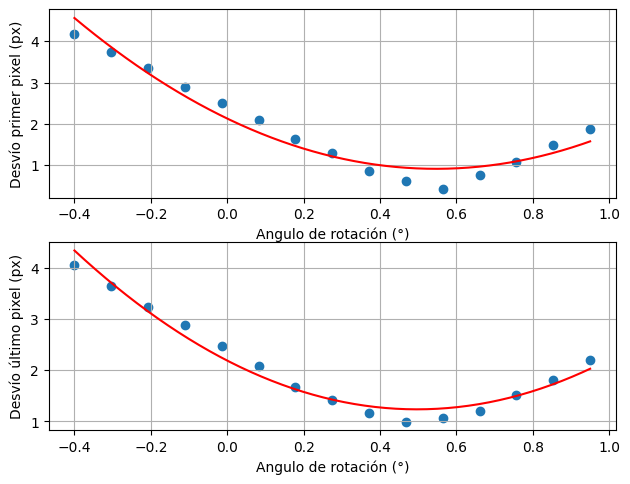

In [18]:
if ENDEREZAR:
      fig, ax = plt.subplots(2)
      fig.tight_layout()
      angulo1 = ridge_grados(grados, results2[:,0], 2, ax[0], label="Desvío primer pixel (px)")
      angulo2 = ridge_grados(grados, results2[:,1], 2, ax[1], label="Desvío último pixel (px)")
      angulo_elegido = (angulo1 + angulo2)/2
else:
      angulo_elegido = 0

Medición final con ángulo elegido

Media inicial: 519.360824742268
Moda: 519
Media final: 519.2409778812573



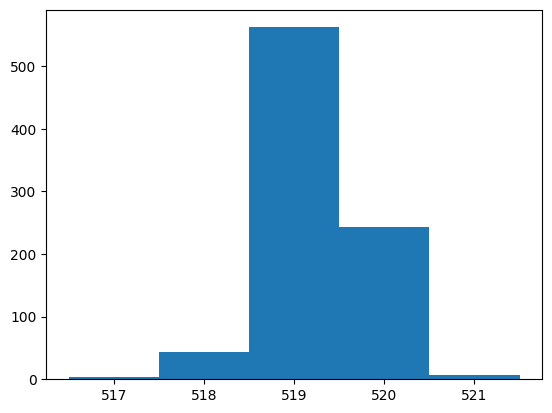

859 filas con media 519.2409778812573 (0.019379335166960877) px



In [19]:
img = rotate_and_cut(patron, angulo_elegido)  # Rota la imagen g grados según lo ajustado
if CANNY:
    edges = Canny_Edges(img, th1, th2)    #Deteccion de bordes
else:
    edges = Thresholding(img, th1, th2)
show_image(edges, SCALE)
cv2.imwrite(DIR + "Pat_Edges.bmp", edges)
diams1 = direct_distance(edges, outlier_percent=0.5, plot=True)   #Mide distancias entre bordes
mean_patron, u_patron = measure_distribution(diams1)   #Guarda las medias y desvios

### DUT

ENDEREZAMIENTO

In [27]:
if ENDEREZAR:
    # Generar vector de grados, si el mínimo de la curva se encuentra
    # muy desplazado, volver a generarlo teniendo eso en cuenta
    grados = np.linspace(-1, 1, 15) # Válido para ángulos pequeños (pueden perderse los bordes al cortar, verificar)
    results = []

    for i,g in enumerate(grados):   # Verifica uno a uno los ángulos
        img = rotate_and_cut(dut, g)  # Rota la imagen g grados
        if CANNY:
            edges = Canny_Edges(img, th1, th2)    #Deteccion de bordes
        else:
            edges = Thresholding(img, th1, th2)
        
        firsts = []
        lasts = []
        for row in edges:
            f = first_pixel(row)
            l = last_pixel(row)
            if f:
                firsts.append(f)
            if l:
                lasts.append(l)
        results.append( [np.std(firsts), np.std(lasts)])

    results = np.array(results)

Desvío primer pixel (px)
Mejor angulo medido: -0.1428571428571429°
Mejor angulo ajustado: 0.3180797210996509°. Score=0.9852052978552973

Desvío último pixel (px)
Mejor angulo medido: 0.2857142857142856°
Mejor angulo ajustado: 0.3732145580176994°. Score=0.9494074352011407



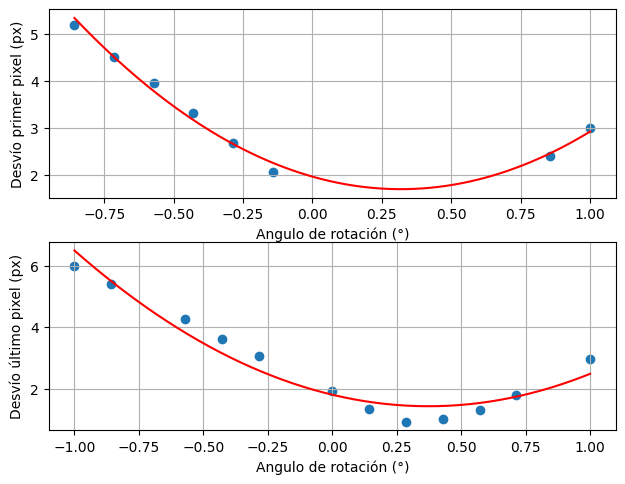

In [28]:
if ENDEREZAR:
      fig, ax = plt.subplots(2)
      fig.tight_layout()
      angulo1 = ridge_grados(grados, results[:,0], 2, ax[0], alpha=0, label="Desvío primer pixel (px)")
      angulo2 = ridge_grados(grados, results[:,1], 2, ax[1], alpha=0, label="Desvío último pixel (px)")
      angulo_elegido = (angulo1 + angulo2)/2
else:
      angulo_elegido = 0

Medición final con ángulo elegido

Media inicial: 959.917808219178
Moda: 960
Media final: 959.917808219178



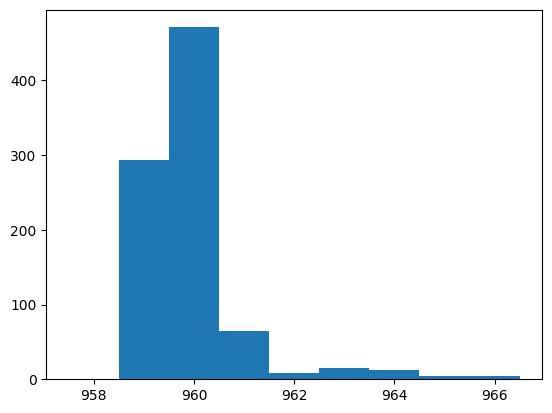

876 filas con media 959.917808219178 (0.03573774476887929) px



In [29]:
img = rotate_and_cut(dut, angulo_elegido)  # Rota la imagen g grados según lo ajustado
if CANNY:
    edges = Canny_Edges(img, th1, th2, L2gradient=True)    #Deteccion de bordes
else:
    edges = Thresholding(img, th1, th2)
cv2.imwrite(DIR + "DUT_Edges.bmp", edges)
show_image(edges, SCALE)
diams1 = direct_distance(edges, outlier_percent=1, plot=True)   #Mide distancias entre bordes
mean_dut, u_dut = measure_distribution(diams1)   #Guarda las medias y desvios

## Cálculo

In [23]:
# ---------------- Parámetros -----------------

DIAMETRO_PATRON = 796.2 # diámetro medido del patrón (micrómetros)
INCERTIDUMBRE_PATRON = 0.6 # incert. patrón

diam_patron = ufloat(DIAMETRO_PATRON, INCERTIDUMBRE_PATRON, id='1', desc="Magnitud del Patrón")
media_patron = ufloat(mean_patron, u_patron, id='2', desc="Media de pixeles del patrón")

media_dut = ufloat(mean_dut, u_dut, id='3', desc="Media de pixeles del DUT")

In [24]:
peso_pixel = diam_patron/media_patron
result = peso_pixel * media_dut

print("Peso de 1 pixel:", peso_pixel, "um")
print(f"El diametro resultante es de {result} micrometros")

Peso de 1 pixel: 1.5336391374120986 ± 0.0011135801473743708 um
El diametro resultante es de 802.4266686790085 ± 0.6297394862233151 micrometros
